<a href="https://colab.research.google.com/github/EdoardoCarlesi/notebooks/blob/main/sicily_wildfire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install geopandas folium geopy sentinelsat rasterio
from sentinelsat import SentinelAPI
from rasterio.plot import show
import rasterio as rio
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import geopy
import folium
import cv2
import re

In [ ]:
# Login into scihub

upwd = pd.read_csv('/content/drive/MyDrive/copernicus_userpwd.csv')

user = upwd['user'].values[0]
password = upwd['password'].values[0]
print(user, password)
url = 'https://scihub.copernicus.eu/dhus'
api = SentinelAPI(user, password, url)

ecarlesi lm741alm741a


In [ ]:
# Find the GPS coordinates of a given place
location = ['Catania, Italy']

# The geocoder function may run out of time, set a proper max timeout
gdf = gpd.tools.geocode(location, timeout=10)

coords = gdf['geometry']
coords_gps = (coords.y[0], coords.x[0])

# Check them out to ensure it is consistent
coords_gps

(37.5024833676144, 15.0878343582247)

In [ ]:
# TODO fix the projection issue using the correct CRS - ideally use a geojson with province boundaries
location_area = coords.buffer(0.2)
map = folium.Map(coords_gps, zoom_start=11)
folium.GeoJson(location_area).add_to(map)
location_area.head()
map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [ ]:
# Query the scihub APIs and get a geodataframe in return

for i in coords:
  footprint = i

products = api.query(footprint, 
                     date = ('20210701', '20210801'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A', 
                     cloudcoverpercentage = (0, 10)
                     )

products_gdf = api.to_geodataframe(products)

# Now get all the available files relative to this GPS coordinates in this time span
filenames = products_gdf['title'].values

In [ ]:
def extract_info(filename):
  '''
    Input:
    - filename is a string with the file name in the post-2016 sentinel format
    
    Output:
    - dictionary with date and tile code for the specific area surveyed
  '''

  tile_str = '_T[A-Z0-9][A-Z0-9][A-Z0-9][A-Z0-9][A-Z0-9]_'
  date_str = '_[0-9][0-9][0-9][0-9][0-9][0-9][0-9][0-9]'

  tile = re.findall(tile_str, filename)
  date = re.findall(date_str, filename)

  info = dict()
  info['tile'] = tile[0].replace('_', '')
  info['date'] = date[0].replace('_', '')

  return info

In [ ]:
# Get the tile code for the first file
info = extract_info(filenames[0])

# Sanity check
info['tile'], info['date']

('T33SWB', '20210731')

In [ ]:
# Sort the snapshots according to some criteria
#products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=True)
products_gdf_sorted = products_gdf.sort_values(['generationdate'], ascending=True)

# Now we want to add the TILE column to sort the snapshots and pick two relative to the same area
products_gdf_sorted['tile'] = products_gdf_sorted['title'].apply(lambda title_str: extract_info(title_str)['tile'])
#products_gdf_sorted.head()

In [ ]:
# From the sorted GeoDF above, extract uuids (used to download the snaps) and tile codes (to ensure the same tile is being downloaded)
img_ids = products_gdf_sorted['uuid'].values
img_tiles = products_gdf_sorted['tile'].values
%cd /content/drive/MyDrive/

# First and last are time-ordered
first_snap = img_ids[0]
last_snap = products_gdf_sorted[products_gdf_sorted['tile'] == img_tiles[0]]['uuid'].values[-1]

#first_snap, last_snap

# Now download the first and last images from Sentinel-2B for the same land tile
#api.download(img_ids[0])
#api.download(last_snap)
#anzip /content/drive/MyDrive/S2B_MSIL2A_20210731T095029_N0301_R079_T33SVB_20210731T120526.zip

/content/drive/MyDrive


In [ ]:
# Sentinel data with different resolution. Run this cell only one time

#resolution = '10m'
resolution = '20m'
#resolution = '60m'

r_paths = ['/content/drive/MyDrive/S2B_MSIL2A_20210701T095029_N0301_R079_T33SVB_20210701T124116.SAFE/GRANULE/L2A_T33SVB_A022556_20210701T095030/IMG_DATA/R'+resolution+'/T33SVB_20210701T095029',
             '/content/drive/MyDrive/S2B_MSIL2A_20210731T095029_N0301_R079_T33SVB_20210731T120526.SAFE/GRANULE/L2A_T33SVB_A022985_20210731T095031/IMG_DATA/R'+resolution+'/T33SVB_20210731T095029']

bands_suffix = ['_B02_'+resolution+'.jp2',
                '_B03_'+resolution+'.jp2',
                '_B04_'+resolution+'.jp2']

# Near infrared (band 8) is available only for 10m files
if resolution == '10m':
  bands_suffix.append('_B08_'+resolution+'.jp2')

# Loop on the different file paths
for i, r_path in enumerate(r_paths):
  bs = []
  out_ndvi = '/content/drive/MyDrive/Images/ndvi_sicili_0'+str(i)+'_'+resolution+'.tiff'
  out_rgb = '/content/drive/MyDrive/Images/rgb_sicili_0'+str(i)+'_'+resolution+'.tiff'

  # Get the selected bands for the given resolution and append them
  for j, band_suffix in enumerate(bands_suffix):
    b = rio.open(r_path + band_suffix)
    bs.append(b)

  # Write the file as a single RGB file summing up the first three bands
  with rio.open(out_rgb, 'w', driver='Gtiff', width=bs[0].width, height=bs[0].height, 
                count=1, crs=bs[0].crs, transform=bs[0].transform, dtype='float64') as rgb:
    for k in range(0,3):
      rgb.write(bs[k].read(1), 1)

    rgb.close()

  # Compute the NDVI index and write it to file only for the 10m resolution
  if resolution == '10m':
    with rio.open(out_ndvi, 'w', driver='Gtiff', width=bs[0].width, height=bs[0].height, 
                count=1, crs=bs[0].crs, transform=bs[0].transform, dtype='float64') as ndvi:
      ndvi_index = (bs[3].read()-bs[2].read()) / (bs[2].read()+bs[3].read())
      ndvi.write(ndvi_index)
 
    ndvi.close()


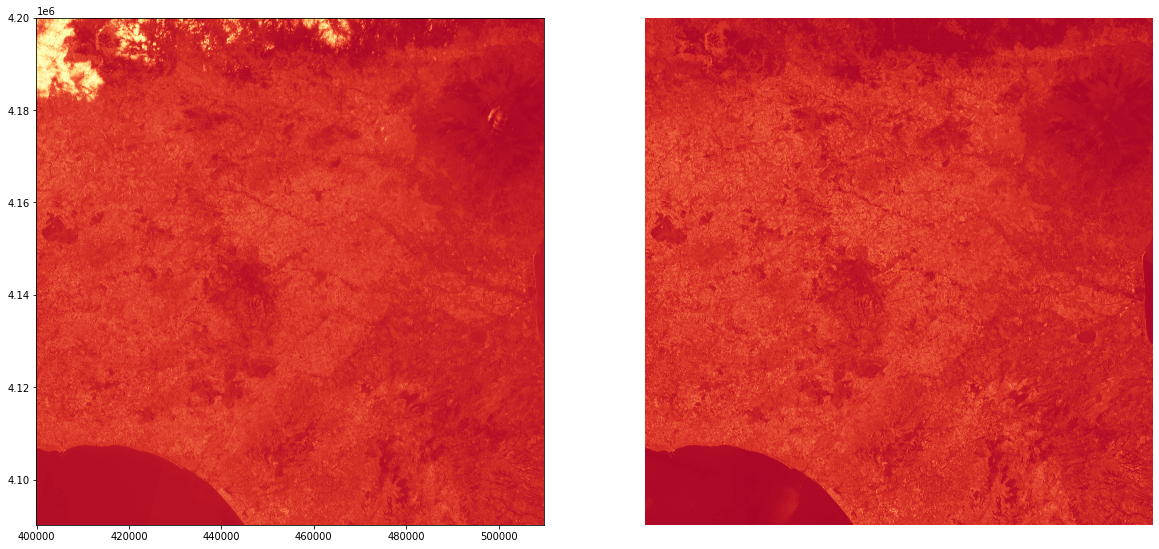

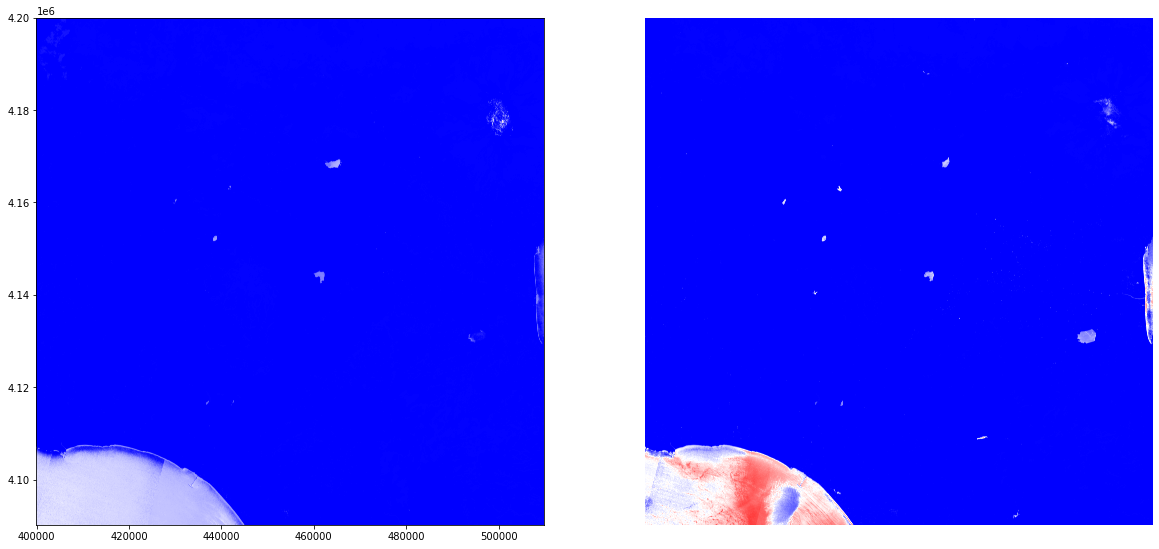

In [ ]:
# Plot the results computed from the snapshots above
resolution = '10m'
#resolution = '20m'
#resolution = '60m'

# Plot all the images alongside
fig, axs = plt.subplots(1,2, figsize=(20, 10))

cmap='RdYlGn'
for i in range(0, 2):
  out_rgb = '/content/drive/MyDrive/Images/rgb_sicili_0'+str(i)+'_'+resolution+'.tiff'
  plt.axis('off')
  show(rio.open(out_rgb), ax=axs[i], cmap=cmap)
  plt.axis('off')

fig, axs = plt.subplots(1,2, figsize=(20, 10))
if resolution == '10m':
  cmap='bwr'
  for i in range(0, 2):
    out_ndvi = '/content/drive/MyDrive/Images/ndvi_sicili_0'+str(i)+'_'+resolution+'.tiff'
    plt.axis('off')
    show(rio.open(out_ndvi), ax=axs[i], cmap=cmap)
    plt.axis('off')
